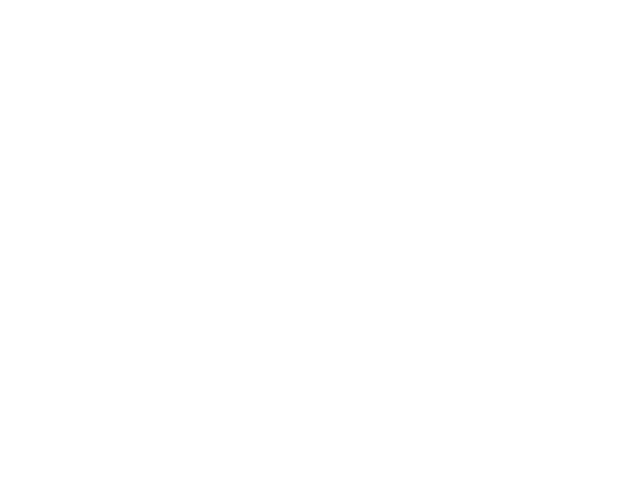

In [5]:
%matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration

import skimage.filters.rank as rank
plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))

class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox

f = imread('../lab_images/cameraman.tif').astype(np.float64)/255
I = imread('../lab_images/degraded.tif').astype(np.float64)/255


1. Compare the restored image with the original image and the blurred image. How does the restored image and the PSNR differ from the blurred image? Is it better or worse? Why?

The restored image looks quite similar to the original image. The restored might be slightly blurred, but overall they look the same. On the other hand, the blurred image is, well, very blurry. Edges are blurred and the image is smoothed. 

The PSNR of the restored image is much higher (~316.61 dB) than the PSNR from the blurred image (~16.31 dB). Hence, the image is much better, which is visually noticeable. It is clear that the quality of the restored image is very good. 

2. Compare the restored image with the restored image from the previous step. How does the restored image and the PSNR differ from the previous restored image? Is it better or worse? Why?

The restored image with added Gaussian noise is significantly worse than the other restored image, with a PSNR of around -41 dB. This extremely low PSNR indicates severe distortion, and we can see that as the image is unrecognizable. This happens as inverse filtering amplifies noise, especially in regions where the frequency response of the blur filter (h_freq) is near zero.

3. Can you draw any conclusions about inverse filtering when applied to noise degraded images?

Hence, inverse filtering is highly sensitive to noise and fails when applied to noisy degraded images. As inverse filtering divides by the frequency response of the blur kernel, it amplifies noise in low-magnitude frequency regions. This makes it unsuitable for images with significant noise. We'll need alternative methods in this case, like Wiener filtering.

4. Compare the restored image with the restored image from the previous step. How does the restored image and the PSNR differ from the previous restored image? Is it better or worse? Why? Explain it in context with the concept behind Wiener filtering.

The restored image using Wiener filtering with a regularization parameter of 0.1 is significantly better than the inverse-filtered image, as we can see visually and in terms of PSNR (~22.68 dB). The balance parameter in the Wiener filtering balances restoring frequencies and suppressing noise artifacts, resulting in a better restoration that doesn't amplify noise excessively.

5. Can you draw any conclusions about Wiener filtering when applied to noise degraded images?

Setting an appropriate regularization parameter in Wiener filtering allows for an effective trade-off between preserving image details and suppressing noise artifacts. This makes Wiener filtering better for restoring noisy degraded images, as it adjusts the restoration process based on the signal-to-noise ratio.

6. Use a flat region of degraded.tif and estimate the variance of the noise (Use the provided Selector class, see the example usage in selector ex.py/selector ex.ipynb).

The estimated variance of the noise is around 0.0108. While calculating K, we end up with some negative values because the local variance may be smaller than the estimated noise variance. If K is negative, the contribution of the local mean would be incorrectly scaled by a value above 1, and the noisy image would be scaled by a negative value, which would distort the restoration process. This could lead to unrealistic image values or negative pixel intensities. Hence, we use np.maximum to get rid of these negative values and set them to zero. This adjustment makes sure that K remains within a valid range [0, 1], reflecting the relative contributions of the noisy image and local mean.

In this case, the PSNR is around 22.18 dB, which suggests a moderate level of noise reduction compared to the original image, though the results still show some visible noise and blurring. The image looks interesting, with some blotchy areas. This is expected for the Lee filter, which adapts based on local image statistics. These blotchy artifacts might be due to the way the Lee filter estimates the noise variance locally. In regions with higher detail or more noise, the filter may not perfectly distinguish between signal and noise, leading to residual noise that appears as blotches. Compared to the Wiener filter, which accounts for both noise and signal characteristics, the Lee filter produces a similar PSNR but the visual quality differs. The Wiener filter tends to smooth out the noise more effectively, which is why the blotchiness is less noticeable in its output.

7. Compare this result to that using a Gaussian low pass filter with standard deviation of 30 (in the frequency domain). Note the performance in areas of high and low detail.

The Gaussian low pass filter with standard deviation 30 smooths the image. 

8. Try varying your estimate of the noise variance both above and below the value you got from your flat region. How does this change the filter’s results? Why?

Decreasing the variance with an order of magnitude 10 (~ 0.001) makes the image grainy. As the variance is lower, it lessens the contribution of the noisy pixels in favor of the local mean. This results in a grainy appearance because the filter reduces the effect of high-frequency noise but also suppresses some of the finer details in the image. The PSNR is around 19.45 dB.

Increasing the variance with an order of magnitude 10 (~ 0.1) makes the filter overly aggressive in smoothing, causing the image to become blurry. The PSNR is around 21.45 dB.

9. Try changing the size of the filter neighborhood to be smaller and larger than 5 × 5. How does this change the results? Why?

When the filter neighborhood size is reduced to 3x3, the smaller area gives less information about local statistics, causing the Lee filter to perform poorly. This leads to an unrecognizable image because the filter struggles to differentiate between noise and details.

On the other land, increasing the neighborhood size to 7x7 allows the filter to get more contextual information, but the results are similar to 5x5. This is because larger neighborhoods don't significantly change the local mean and variance calculations in relatively smooth regions, keeping similar overall performance.